## **1. Importing modules and libraries**

In [1]:
import os
import torch

# torchvision contains many popular computer vision datasets, deep neural network architectures, and image processing modules.
import torchvision

# torch.nn contains the deep learning neural network layers such as Linear(), and Conv2d().
import torch.nn as nn

#  functional:  we will use this for activation functions such as ReLU.
import torch.nn.functional as F

from torchvision import datasets
from torchvision.transforms import transforms

# save_image: torchvision.utils provides this module to easily save PyTorch tensor images.
from torchvision.utils import make_grid, save_image

# Dataloader: eases the task of making iterable training and testing sets.
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

# torch.optim contains the deep learning optimizer classes such as MSELoss() and many others as well.
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

from tqdm.notebook import tqdm

In [2]:
transform = transforms.Compose([transforms.ToTensor()])                           # converts images or numpy arrays to tensors

train_set = datasets.CIFAR10(root='./data/', train = True, download=True, transform=transform)
test_set = datasets.CIFAR10(root='./data/', train=False, transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data/


In [3]:
print("no of training images:",len(train_set))
print("no of test images:",len(test_set))

#classes = train_set.classes
#classes

no of training images: 50000
no of test images: 10000


In [4]:
batch_size = 64

# preparing data loaders 
train_loader = DataLoader(train_set, batch_size, num_workers=2, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_set, batch_size*2, num_workers=2, pin_memory=True)


training_batch = next(iter(train_loader))
test_batch = next(iter(test_set))
print(type(training_batch))                             # <class 'list'> First element of list is a list of Image Tensor 
print(len(training_batch))                              # 2  ( )
print(type(training_batch[1]))
print(training_batch[0].shape)                          # shape of all images in a batch
print(training_batch[1].shape)                          # this shows the size of labels
print(training_batch[0][0].shape)                       # Returns shape of 1st image out of 32 images
print(training_batch[1][0])

<class 'list'>
2
<class 'torch.Tensor'>
torch.Size([64, 3, 32, 32])
torch.Size([64])
torch.Size([3, 32, 32])
tensor(4)


## **Adding noise to training images**

In [5]:
noise_factor = 0.15

# noise to training images
train_dataiter = iter(train_loader)
train_images, train_labels = next(train_dataiter)                                                
train_images_noisy = train_images + noise_factor * torch.randn(train_images.shape)           # shape = torch.Size([32, 3, 32, 32])
train_images_noisy = np.clip(train_images_noisy, 0., 1.)                                     # clip to make the values fall between 0 and 1

#train_images = train_images.numpy() 
#train_images_noisy=train_images_noisy.numpy()

def showOrigDec(orig, noise, num=10):
    import matplotlib.pyplot as plt
    n = num
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i+1)
        plt.imshow(train_images[i].permute(1,2,0))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display noisy
        ax = plt.subplot(2, n, i +1 + n)
        plt.imshow(train_images_noisy[i].permute(1,2,0))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.figtext(0.5,0.95, "ORIGINAL IMAGES", ha="center", va="top", fontsize=14, color="r")
    plt.figtext(0.5,0.5, "NOISY IMAGES", ha="center", va="top", fontsize=14, color="r")
    plt.subplots_adjust(hspace = 0.3 )
        
    plt.show()

# Given a Tensor representing the image, use .permute() to put the channels as the last dimension. Not using permute method will throw an error of "TypeError:Invalid shape (3, 32, 32) for image data"




## **Plotting Original and Noisy Images**

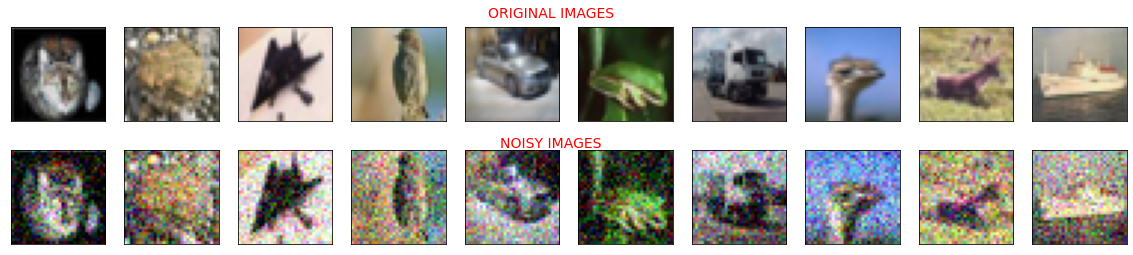

In [6]:
showOrigDec(train_images,train_images_noisy)

# **Defining the Autoencoder Network**

In [7]:
# autoencoder model

class Autoencoder(nn.Module):
    # in def_init__    function we define all the layers that we will use to build the network
    def __init__(self):
        super(Autoencoder, self).__init__()
        # encoder layers
        self.enc1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)                   # in_channel =3, out_channel = 64
        self.enc2 = nn.Conv2d(64, 32, kernel_size=3, padding=1)                  # in_channel =64, out_channel = 32
        self.enc3 = nn.Conv2d(32, 16, kernel_size=3, padding=1)                  # in_channel =32, out_channel = 16
        self.enc4 = nn.Conv2d(16, 8, kernel_size=3, padding=1)                   # in_channel =16, out_channel = 8
        self.pool = nn.MaxPool2d(2, 2)                                           # both kernels and stride with value 2
        
        # decoder layers     ( consists of ConvTranspose Layer )
        # we keep on increasing the dimensionality till we get 64 out_channels in self.dec4.
        self.dec1 = nn.ConvTranspose2d(8, 8, kernel_size=2, stride=2)  
        self.dec2 = nn.ConvTranspose2d(8, 16, kernel_size=2, stride=2)
        self.dec3 = nn.ConvTranspose2d(16, 32, kernel_size=2, stride=2)
        self.dec4 = nn.ConvTranspose2d(32, 64, kernel_size=2, stride=2)
        # nn.Conv2d() layer with 3 output channel so as to reconstruct the original image.
        self.out = nn.Conv2d(64, 3, kernel_size=3, padding=1)
    def forward(self, x):
        # encode
        x = F.relu(self.enc1(x))                                                             # 32 * 32
        x = self.pool(x)                                                                     # 16 * 16
        x1 = F.relu(self.enc2(x))                                                            # 16 * 16
        x = self.pool(x1)                                                                    # 8 * 8 
        x2 = F.relu(self.enc3(x))                                                            # 8 * 8
        x = self.pool(x2)                                                                    # 4 * 4
        x3 = F.relu(self.enc4(x))                                                            # 4 * 4
        x = self.pool(x3) # the latent space representation of input data                    # 2 * 2
        # decode
        x = F.relu(self.dec1(x))                                                             # 4 * 4
        x = x3 + x                                                        
        x = F.relu(self.dec2(x))                                                             # 8 * 8
        x = x2 + x
        x = F.relu(self.dec3(x))                                                             # 16 * 16
        x = x1 + x
        x = F.relu(self.dec4(x))                                                             # 32 * 32
        x = torch.sigmoid(self.out(x))                                                       # 32 * 32
        return x
net = Autoencoder()
print(net)

Autoencoder(
  (enc1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc4): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dec1): ConvTranspose2d(8, 8, kernel_size=(2, 2), stride=(2, 2))
  (dec2): ConvTranspose2d(8, 16, kernel_size=(2, 2), stride=(2, 2))
  (dec3): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (dec4): ConvTranspose2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
  (out): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


## **Optimizer and Loss** **Function** 

In [8]:
# loss function
criterion = nn.MSELoss()                # mean squared error to calculate the dissimilarity between the original pixel values and the predicted pixel values.
# optimizer
learning_rate = 0.001
optimizer = optim.Adam(net.parameters(), lr= learning_rate)

In [9]:
# print(type(train_loader))                                                       # <class 'torch.utils.data.dataloader.DataLoader'>
for images, labels in train_loader:
  print(images.shape)
  print(labels)
  break

torch.Size([64, 3, 32, 32])
tensor([4, 3, 7, 8, 5, 3, 0, 8, 1, 0, 4, 5, 0, 6, 1, 2, 6, 7, 4, 1, 0, 9, 0, 5,
        3, 5, 3, 7, 1, 0, 3, 9, 3, 8, 7, 1, 6, 8, 8, 8, 4, 5, 4, 8, 9, 7, 0, 6,
        9, 4, 4, 5, 3, 6, 4, 6, 2, 3, 6, 4, 3, 1, 3, 5])


Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


# Defining the training function

In [10]:
# training function

num_epochs = 5

def train(net, train_loader, num_epochs):
  training_loss = []
  for epoch in tqdm(range(num_epochs)):
    running_loss = 0.0

    for images, labels in train_loader:                                          
      # adding random noise to the input training images
      train_image_noisy = images + noise_factor * torch.randn(images.shape)
      train_image_noisy = np.clip(train_image_noisy, 0., 1.)                        # clip to make the values fall between 0 and 1

      optimizer.zero_grad()                                                         # clearing the all optimized gradients to zero at the beginning of each batch
      model_output = net(train_image_noisy)                                         # compute predicted outputs by passing *noisy* images to the model
      loss = criterion(model_output, images)                                        # loss calculation
      loss.backward(retain_graph=True)                                              # backpropagating the gradients to compute gradient of the loss with respect to model parameters
      optimizer.step()                                                              # updating the parameters
      running_loss += loss.item()                                                   # adding the losses to "running_loss" variable

    loss = running_loss / len(train_loader)                                         # print average training statistics
    training_loss.append(loss)
    print('Epoch {} / {}, Train Loss: {:.3f}'.format(
            epoch+1, num_epochs, loss))
    
  return training_loss




  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 / 5, Train Loss: 0.007
Epoch 2 / 5, Train Loss: 0.004
Epoch 3 / 5, Train Loss: 0.004
Epoch 4 / 5, Train Loss: 0.003
Epoch 5 / 5, Train Loss: 0.003


Text(0, 0.5, 'Loss')

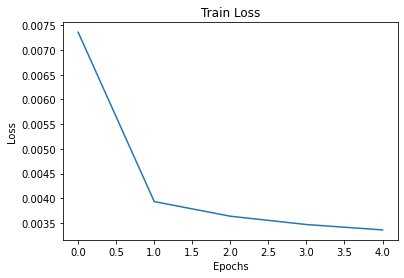

In [11]:
train_loss = train(net, train_loader, num_epochs)
plt.figure()
plt.plot(train_loss)
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [12]:
# adding noise to test images
#test_dataiter = iter(test_loader)

# obtaining one batch of test images
test_images, test_labels = next(iter(test_loader))                                                
test_images_noisy = test_images + noise_factor * torch.randn(test_images.shape)       # shape = torch.Size([32, 3, 32, 32])
test_images_noisy = np.clip(test_images_noisy, 0., 1.)                                # clip to make the values fall between 0 and 1

#test_images = test_images.numpy() 
#test_images_noisy=test_images_noisy.numpy()

# get sample outputs
output = net(test_images_noisy)
output = output.detach()

# output is resized into a batch of iages
#output = output.view(batch_size, 3, 32, 32)

In [13]:
for test_images, test_labels in test_loader:
  print(test_images.shape)
  print(test_labels)
  break

torch.Size([128, 3, 32, 32])
tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9,
        5, 2, 4, 0, 9, 6, 6, 5, 4, 5, 9, 2, 4, 1, 9, 5, 4, 6, 5, 6, 0, 9, 3, 9,
        7, 6, 9, 8, 0, 3, 8, 8, 7, 7, 4, 6, 7, 3, 6, 3, 6, 2, 1, 2, 3, 7, 2, 6,
        8, 8, 0, 2, 9, 3, 3, 8, 8, 1, 1, 7, 2, 5, 2, 7, 8, 9, 0, 3, 8, 6, 4, 6,
        6, 0, 0, 7, 4, 5, 6, 3, 1, 1, 3, 6, 8, 7, 4, 0, 6, 2, 1, 3, 0, 4, 2, 7,
        8, 3, 1, 2, 8, 0, 8, 3])


In [14]:
def Results(orig, noise, denoise, num=10):
    import matplotlib.pyplot as plt
    n = num
    plt.figure(figsize=(20, 6))

    for i in range(n):
        # display original
        ax = plt.subplot(3, n, i+1)
        plt.imshow(test_images[i].permute(1,2,0))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display noisy image
        ax = plt.subplot(3, n, i +1 + n)
        plt.imshow(test_images_noisy[i].permute(1,2,0))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display denoised image
        ax = plt.subplot(3, n, i +1 + n + n)
        plt.imshow(denoise[i].permute(1,2,0))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    plt.figtext(0.5,0.95, "Original test images", ha="center", va="top", fontsize=14, color="r")
    plt.figtext(0.5,0.65, "Noisy test images", ha="center", va="top", fontsize=14, color="g")
    plt.figtext(0.5,0.35, " Denoised test images", ha="center", va="top", fontsize=14, color="b")
    plt.subplots_adjust(hspace = 0.5 )
    plt.show()

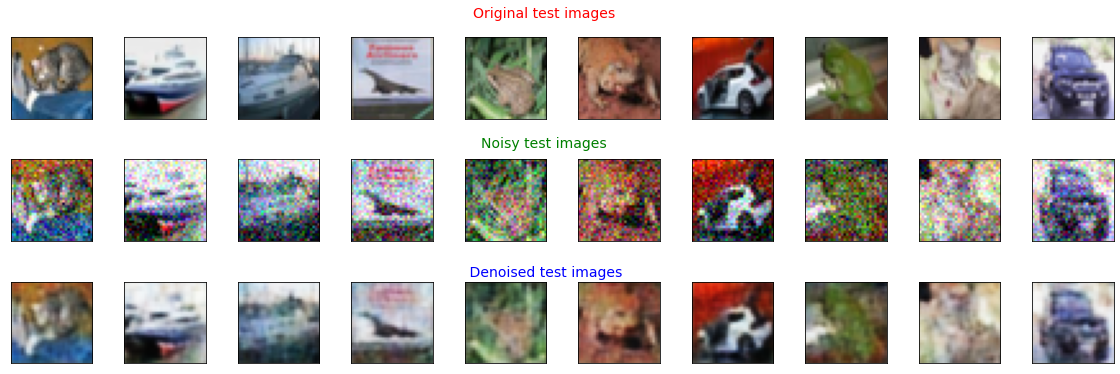

In [15]:
Results(test_images, test_images_noisy, output)